# Human Body Segmentation
This notebook uses Python version of Google's [BodyPix API](https://blog.tensorflow.org/2019/11/updated-bodypix-2.html) to identify face, arms and torso of drivers in each image of our dataset. Idea is to first isolate the body segments and then compute local features for training.

Reference inference implementation: 
* https://www.kaggle.com/code/rkuo2000/bodypix
* https://www.kaggle.com/code/rkuo2000/bodypix

## Prerequesites
Install the bodypix library using
```
!pip install tf-bodypix
!pip install tfjs-graph-converter
```

## TODO
* Establish a pipeline that processes all the training data (and test data for now) to create the segmentation map or bounding box as required.

In [1]:
import cv2
import tensorflow as tf
from tf_bodypix.api import load_model, download_model, BodyPixModelPaths
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import random
import time
import statistics

class_dict = {0 : "Safe Driving",
              1 : "Texting (right)",
              2 : "Phone Call (right)",
              3 : "Texting(left)",
              4 : "Phone Call(left)",
              5 : "Fiddling With Console",
              6 : "Drinking",
              7 : "Reaching Back",
              8 : "Fixing Looks",
              9 : "Conversing"}

PART_CHANNELS = [
    'left_face',
    'right_face',
    'left_upper_arm_front',
    'left_upper_arm_back',
    'right_upper_arm_front',
    'right_upper_arm_back',
    'left_lower_arm_front',
    'left_lower_arm_back',
    'right_lower_arm_front',
    'right_lower_arm_back',
    'left_hand',
    'right_hand',
    'torso_front',
    'torso_back',
    'left_upper_leg_front',
    'left_upper_leg_back',
    'right_upper_leg_front',
    'right_upper_leg_back',
    'left_lower_leg_front',
    'left_lower_leg_back',
    'right_lower_leg_front',
    'right_lower_leg_back',
    'left_feet',
    'right_feet'
]

parts_of_interest = [
    'left_face',
    'right_face',
    'left_upper_arm_front',
    'left_upper_arm_back',
    'right_upper_arm_front',
    'right_upper_arm_back',
    'left_lower_arm_front',
    'left_lower_arm_back',
    'right_lower_arm_front',
    'right_lower_arm_back',
    'left_hand',
    'right_hand',
    'torso_front',
    'torso_back'
]

INPUT_FOLDER = '../input'
OUTPUT_FOLDER = '../output'
TRAIN_DATA = f'{INPUT_FOLDER}/state-farm-distracted-driver-detection/imgs/train'
TEST_DATA = f'{INPUT_FOLDER}/state-farm-distracted-driver-detection/imgs/test'
TRAIN_DATA_FULL = f'{INPUT_FOLDER}/state-farm-distracted-driver-detection/imgs/train_orig'

# IMAGES_BASE = '/Users/rasentha/mids/w281/project/test_images'
IMAGES_BASE = TRAIN_DATA_FULL

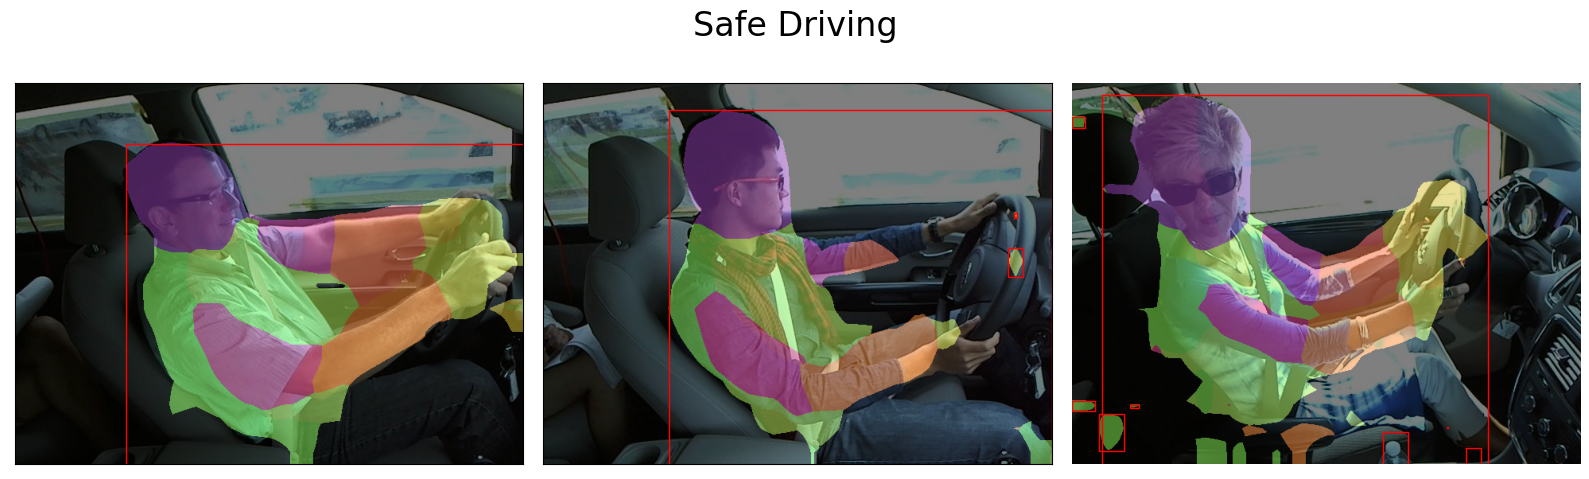

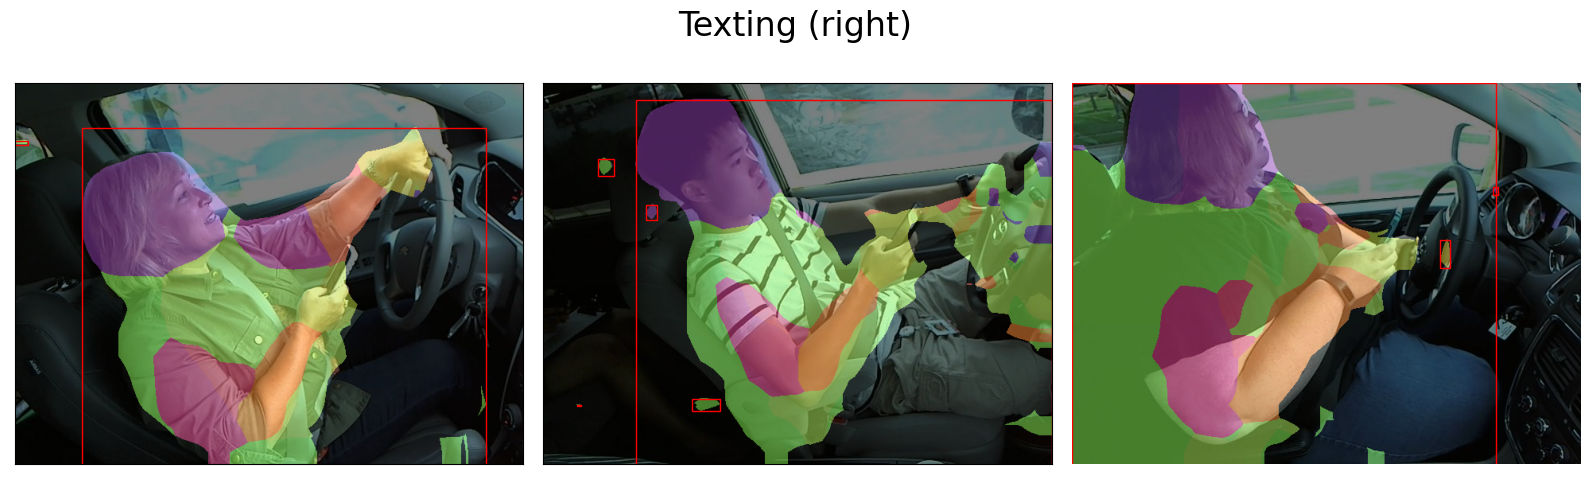

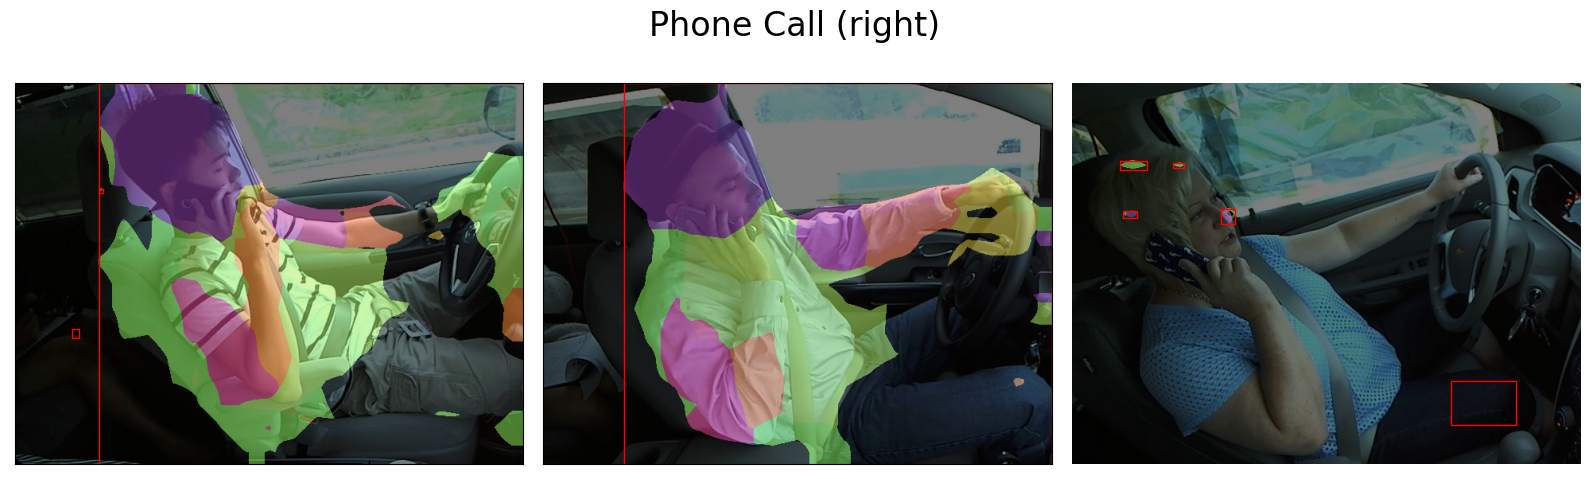

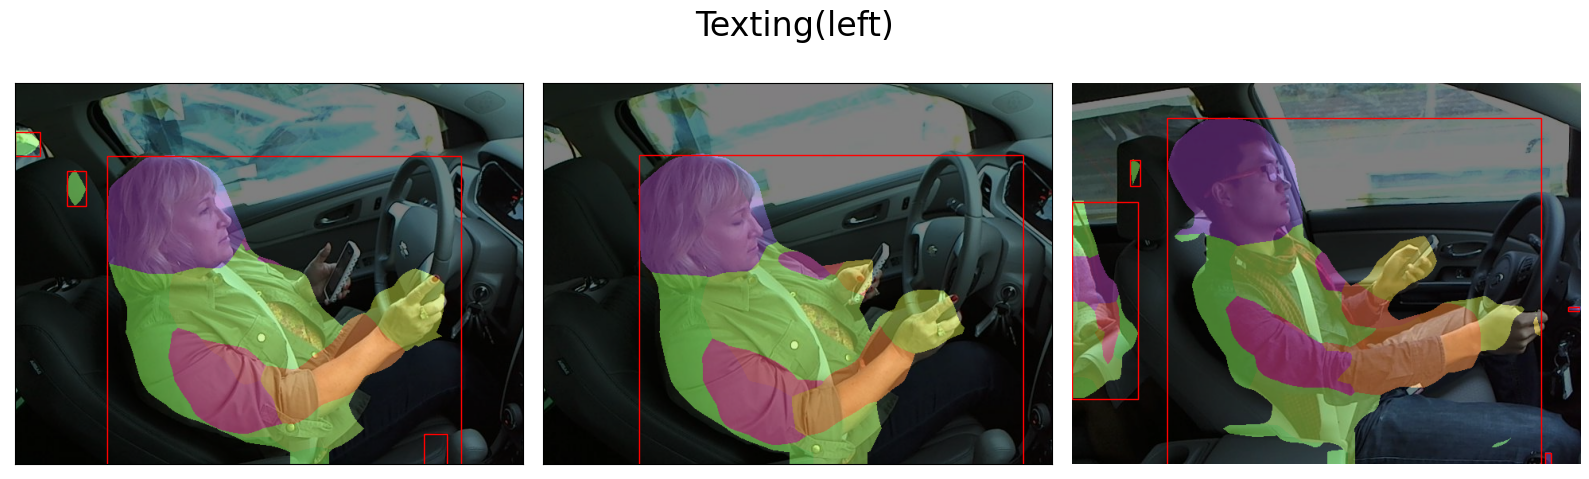

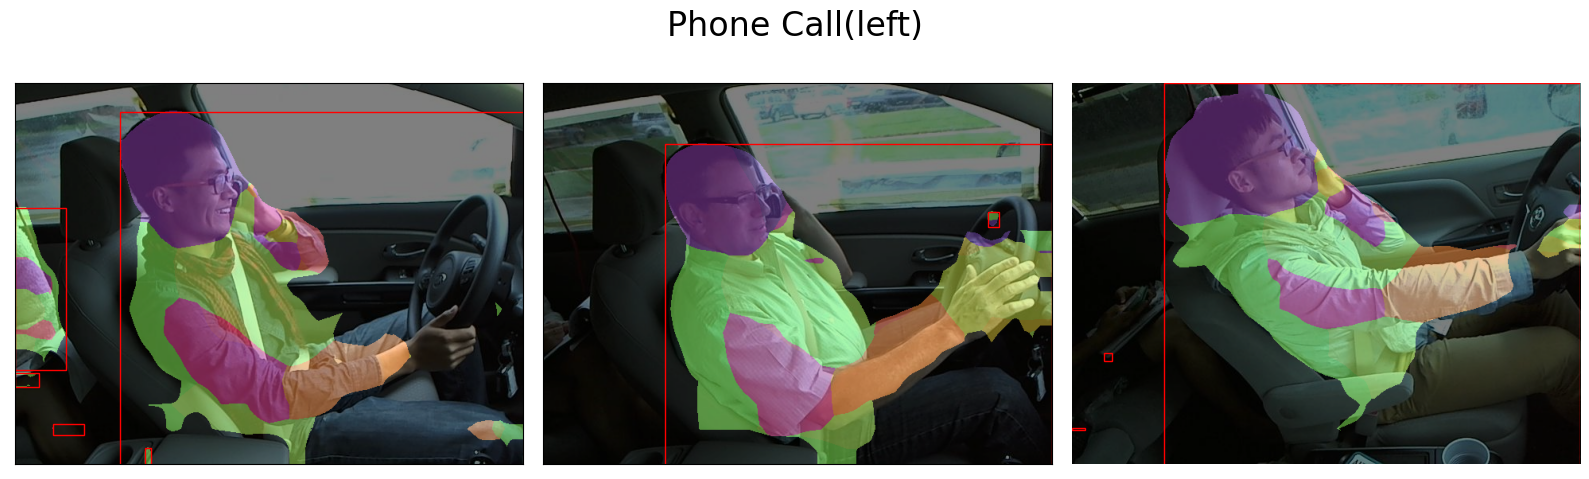

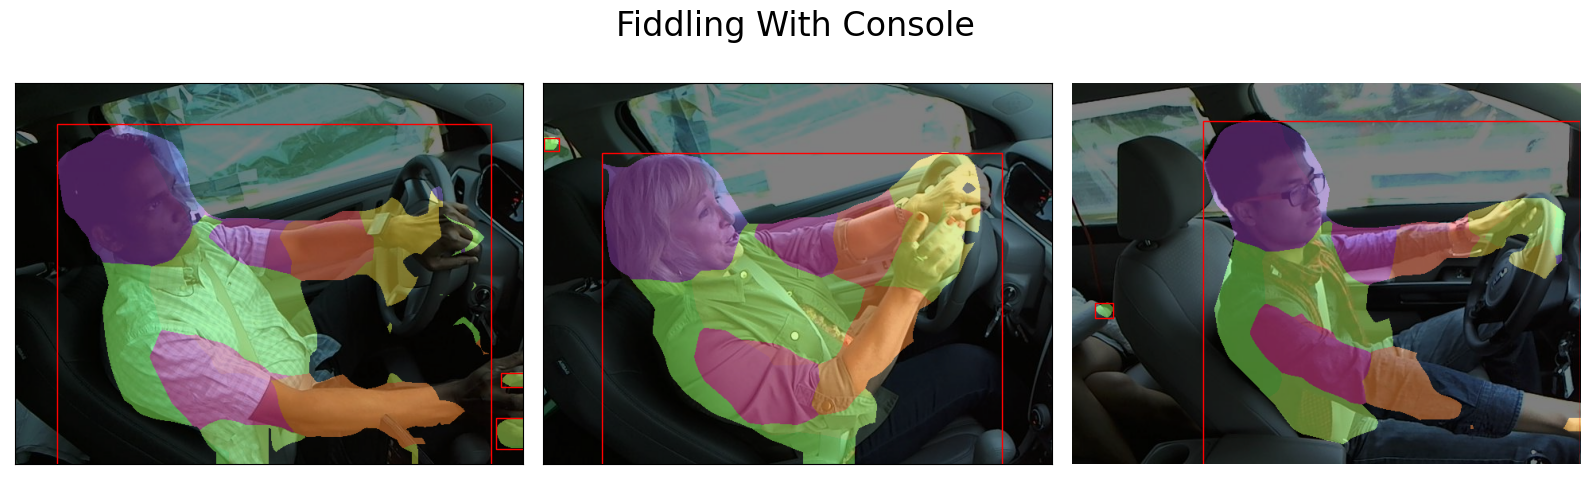

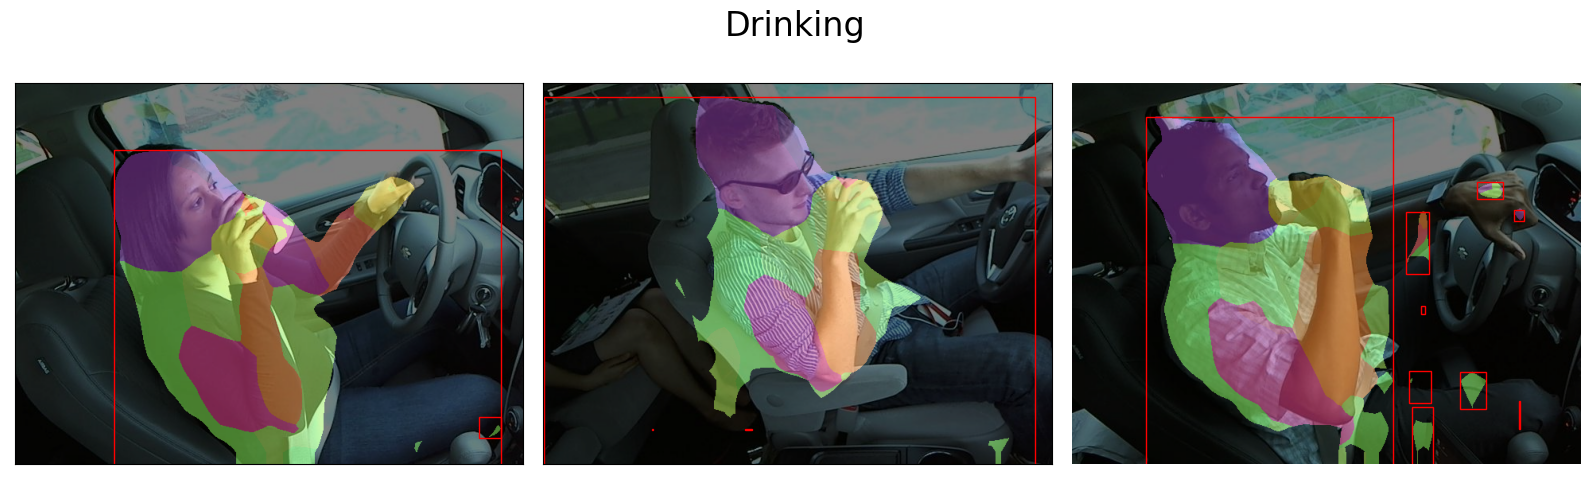

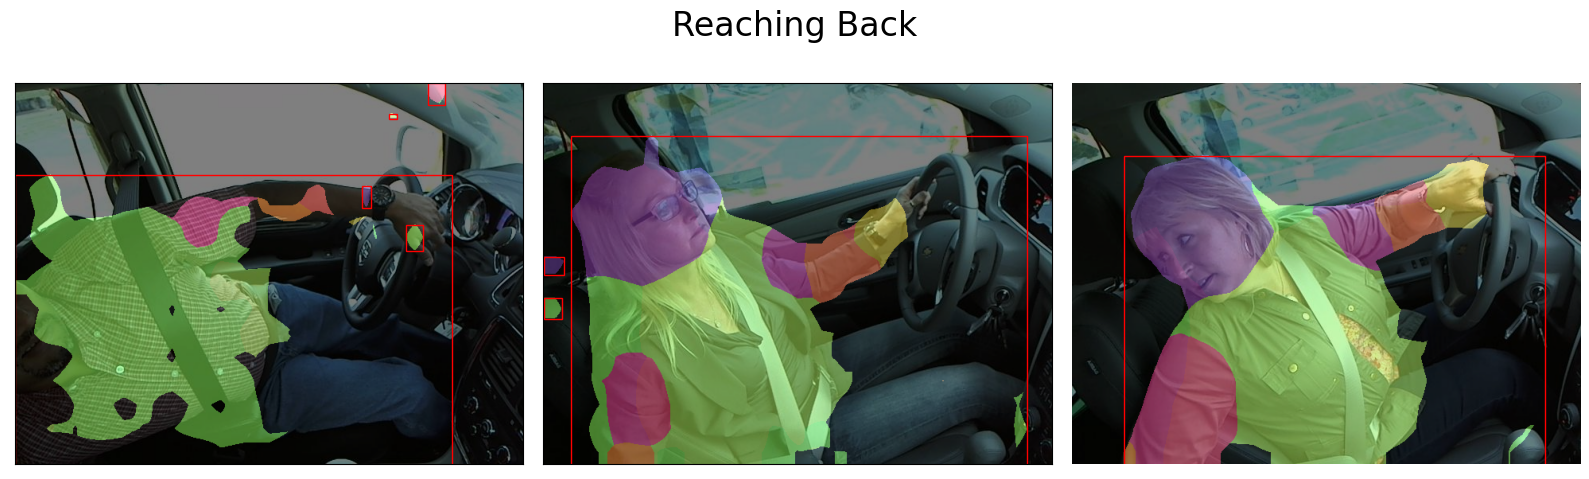

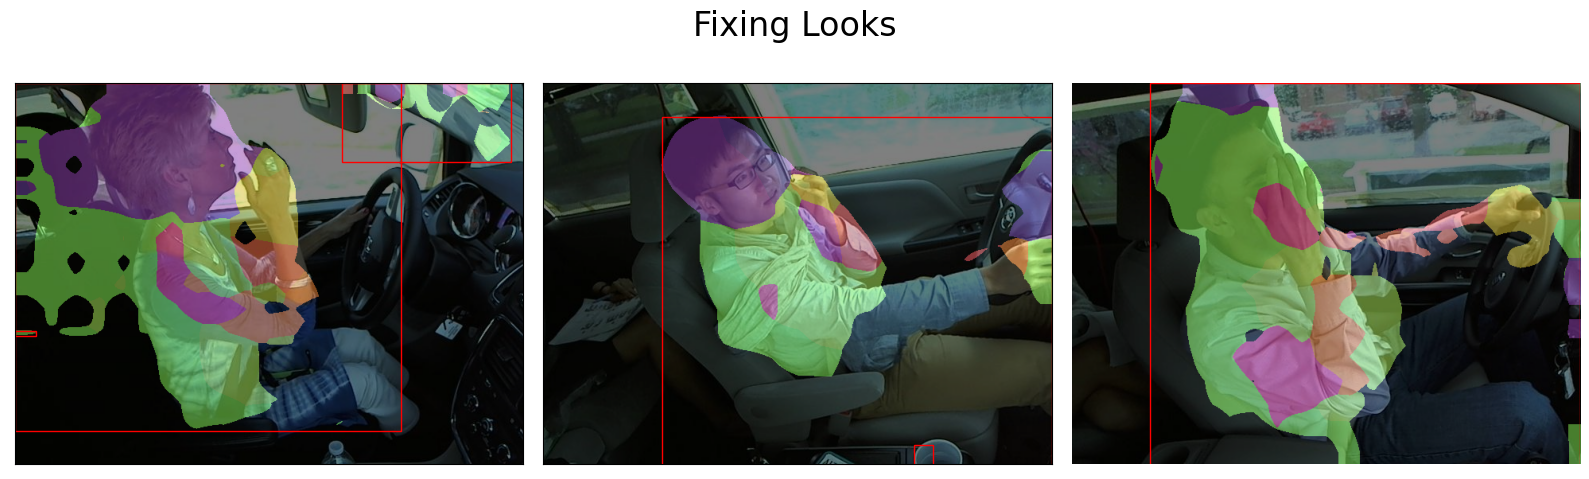

Average time for inference:1.4335693333333381 seconds
Anticipated preprocessing time for training dataset of 22,000:525.6420888888907 mins


In [2]:
def get_model():
        # Available models:
    # MOBILENET_FLOAT_50_STRIDE_8
    # MOBILENET_FLOAT_50_STRIDE_16
    # MOBILENET_FLOAT_75_STRIDE_8
    # MOBILENET_FLOAT_75_STRIDE_16
    # MOBILENET_FLOAT_100_STRIDE_8
    # MOBILENET_FLOAT_100_STRIDE_16
    # RESNET50_FLOAT_STRIDE_16
    # RESNET50_FLOAT_STRIDE_32

    # bp_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))
    # MOBILENET_FLOAT_75_STRIDE_8
    # MOBILENET_FLOAT_100_STRIDE_8
    # MOBILENET_FLOAT_75_STRIDE_16
    # MOBILENET_FLOAT_100_STRIDE_16
    # bp_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_100_STRIDE_16))
    bp_model = load_model(download_model(BodyPixModelPaths.RESNET50_FLOAT_STRIDE_16))
    return bp_model

    
def infer(ax, bp_model, image_file, parts=True):
    image = cv2.imread(image_file)
    start = time.process_time()
    prediction = bp_model.predict_single(image) # Passing the image to the model
    time_taken = time.process_time() - start
    mask = prediction.get_mask(threshold=0.2).numpy().astype(np.uint8)
    part_masks = prediction.get_part_mask(mask, part_names=parts_of_interest)
    # colored_mask = prediction.get_colored_part_mask(mask)
    colored_mask = prediction.get_colored_part_mask(mask, part_names=parts_of_interest)
    # new_mask = cv2.bitwise_and(image, image, mask=mask)
    masked = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 0.5, colored_mask, 0.5, 0, dtype = cv2.CV_8U)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    if len(bounding_boxes)>0:
        for x,y,w,h in bounding_boxes:
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    ax.imshow(masked)
    # ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return time_taken
    
def infer_all(bp_model, title, folder_name, num_images=9, cols=3, plt_width=16, plt_height=5):
    files = list(glob.glob(folder_name + '/*.jpg'))
    rows = num_images // cols
    rows = rows if rows * cols >= num_images else rows + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(plt_width, plt_height))
    axes = np.array(axes).flatten().tolist()
    times = []
    for i in range(num_images):
        ax = axes[i]
        filename = random.choice(files)
        times.append(infer(ax, bp_model, filename))
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.axis('off')
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    # print(f'Average time for inference for class \'{title}\':{statistics.mean(times)} seconds')
    # print('')
    return times

# infer("/Users/rasentha/mids/w281/project/w281-fall2022-section2-team3/input/state-farm-distracted-driver-detection/imgs/test_10/img_24.jpg")
bp_model = get_model()
for cur_class in range(9):
    times = []
    times = [*times, *infer_all(bp_model, class_dict[cur_class], f'{IMAGES_BASE}/c{cur_class}', num_images=3, cols=3)]

print(f'Average time for inference:{statistics.mean(times)} seconds')
print(f'Anticipated preprocessing time for training dataset of 22,000:{22000 * statistics.mean(times) / 60} mins')
    